Датасет:

https://archive.ics.uci.edu/ml/datasets/abalone

Задача - класифікация

Обов'язкові кроки:

первинний аналіз даних (відстуність пропусків, наявність категоріальних фіч, ...)
фича інжиніринг (побудувати 1-2 нові фічі)
масштабування фіч
поділ датасету на тренувальну, валідаційну та тестову частини
тренування базової моделі із дефолтними гіперпараметрами
підбір гіперпараметрів
оцінка результатів (розрахунок метрик, побудова кривих)

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [39]:
database = pd.read_csv("abalone.data", sep=',', 
names=['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'])

In [40]:
database

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [41]:
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


C:\Users\kolya\AppData\Local\Temp\ipykernel_53168\17353128.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(database.corr())


<AxesSubplot: >

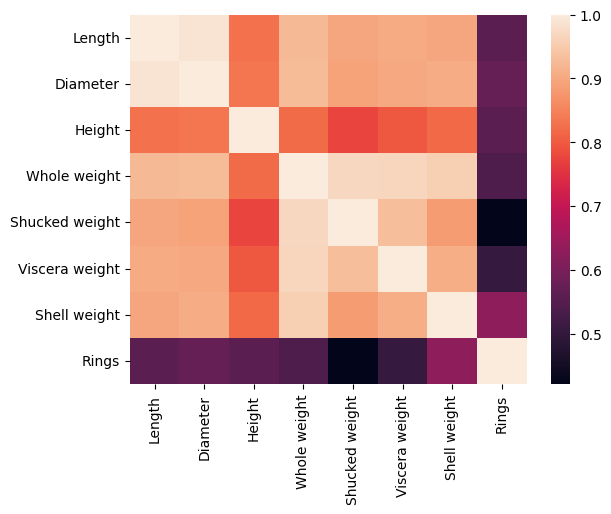

In [42]:
sns.heatmap(database.corr())

все фичи, кроме количества колец между собой коррелюют, нужно менять и добавлять новые.

пробуем ввести следующие фичи:
1. 'Ratio' Отношение длины к диаметру
2. 'Weight loss' Отношение внутреннего веса(Viscera weight) к сброшенному весу(Shucked weight)
3. 'Global density' Плотность (отношение всего веса к произведению длины, диаметра и высоты)
4. 'Shell density' Плотность ракушки (отношение веса ракушки к 2м произвденниям длины на диаметр)
5. 'Fleshiness' Отношение всего веса к весу ракушки

In [43]:
database['Ratio'] = database['Length'] / database['Diameter']
database['Weight loss'] = database['Viscera weight'] / database['Shucked weight']
database['Shell density'] = database['Shell weight'] / (2 * database['Length'] * database['Diameter'])
database['Fleshiness'] = database['Whole weight'] / database['Shell weight']
database['Global density'] = (database['Diameter'] * database['Height'] * database['Length']) / database['Whole weight']

C:\Users\kolya\AppData\Local\Temp\ipykernel_53168\17353128.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(database.corr())


<AxesSubplot: >

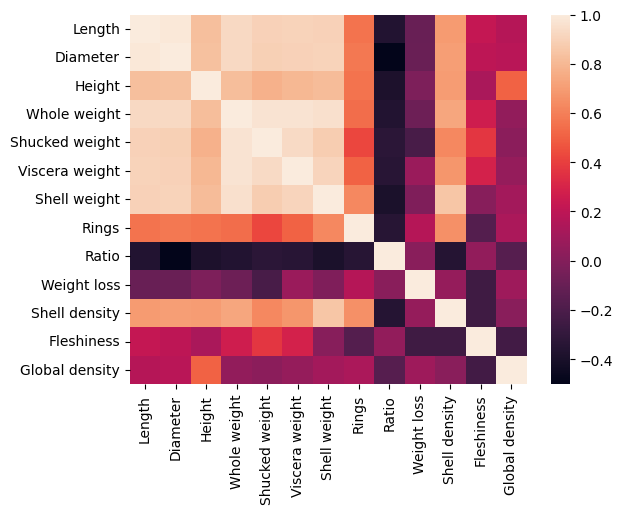

In [44]:
sns.heatmap(database.corr())

In [45]:
dct = {'M': 10, 'F': 20, 'I': -1}
database['Sex_numeric'] = database['Sex'].map(dct)

удаляем корреллющие фичи

In [46]:
database = database.drop(columns = ['Diameter', 'Shucked weight', 'Viscera weight', 'Shell weight'])

In [47]:
database

,Sex,Length,Height,Whole weight,Rings,Ratio,Weight loss,Shell density,Fleshiness,Global density,Sex_numeric
0,M,0.455,0.095,0.5140,15,1.246575,0.449889,0.451603,3.426667,0.030695,10
1,M,0.350,0.090,0.2255,7,1.320755,0.487437,0.377358,3.221429,0.037018,10
2,F,0.530,0.135,0.6770,9,1.261905,0.551657,0.471698,3.223810,0.044388,20
3,M,0.440,0.125,0.5160,10,1.205479,0.529002,0.482565,3.329032,0.038905,10
4,I,0.330,0.080,0.2050,7,1.294118,0.441341,0.326797,3.727273,0.032839,-1
...,...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.165,0.8870,11,1.255556,0.645946,0.489676,3.562249,0.047296,20
4173,M,0.590,0.135,0.9660,10,1.340909,0.488610,0.501733,3.708253,0.036280,10
4174,M,0.600,0.205,1.1760,9,1.263158,0.547098,0.540351,3.818182,0.049681,10
4175,F,0.625,0.150,1.0945,10,1.288660,0.491525,0.488247,3.697635,0.041543,20


C:\Users\kolya\AppData\Local\Temp\ipykernel_53168\17353128.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(database.corr())


<AxesSubplot: >

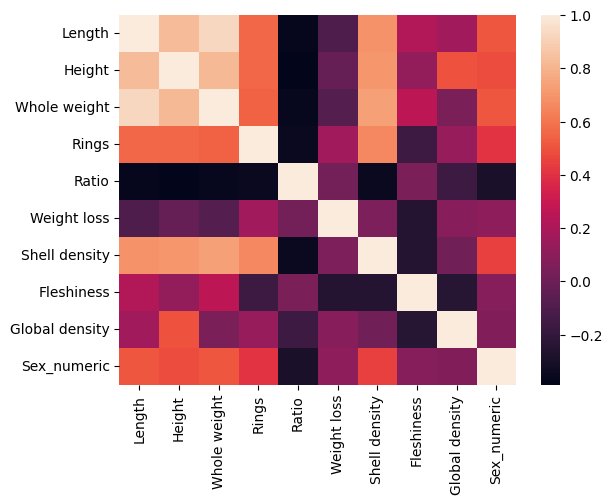

In [48]:
sns.heatmap(database.corr())

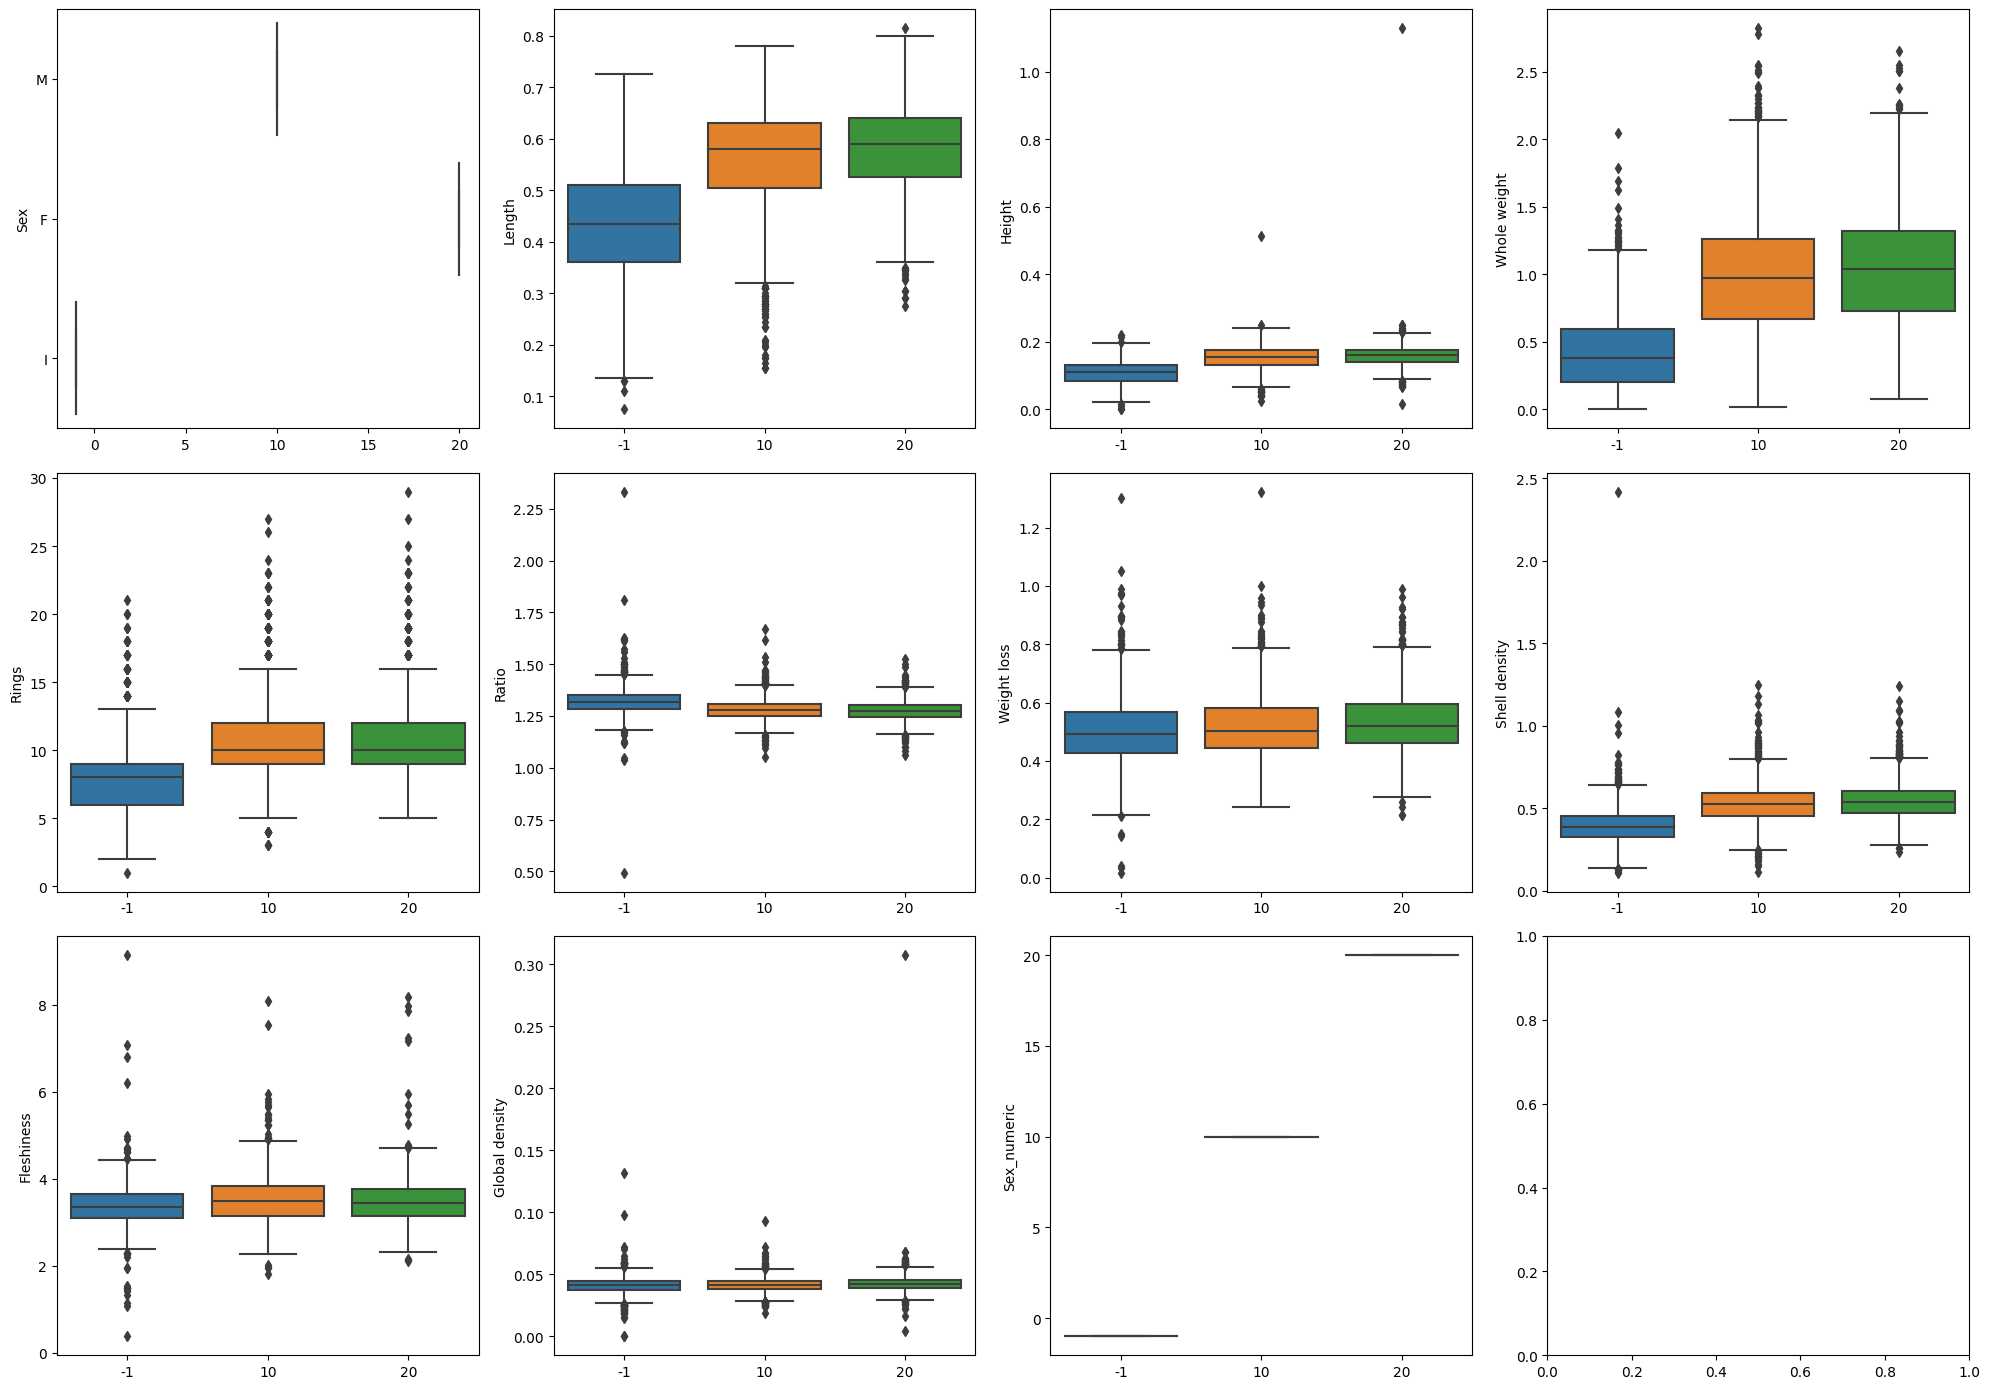

In [49]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (20, 14))
for idx, feat in enumerate(database):
    ax = axes[int(idx/4), idx % 4]
    sns.boxplot(database, x="Sex_numeric", y=feat, ax = ax)
    ax.set_xlabel("")
    ax.set_ylabel(feat)
fig.tight_layout()

видно что мужские осыби и женские осыби очень похожи по характеристикам, их разделить может не получится, но попробуем все таки работать с тремя классами.

In [50]:
y = np.array(database['Sex_numeric'])
X = database.drop(columns= ['Sex_numeric', 'Sex'])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [52]:
reg = make_pipeline(StandardScaler(),KNeighborsClassifier())

In [53]:
reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [54]:
reg.score(X_test, y_test)

0.5454545454545454

In [55]:
print(classification_report(y_test, reg.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.67      0.79      0.73       291
          10       0.46      0.50      0.48       296
          20       0.46      0.31      0.37       249

    accuracy                           0.55       836
   macro avg       0.53      0.53      0.53       836
weighted avg       0.53      0.55      0.53       836



In [56]:
from sklearn.metrics import classification_report

In [57]:
param_grid = {'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],'kneighborsclassifier__weights': ['uniform', 'distance'], 
              'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree'], 'kneighborsclassifier__p': [1, 2, 3]}

In [58]:
clf = GridSearchCV(reg, param_grid)

In [59]:
for param in clf.get_params().keys():
    print(param)

cv
error_score
estimator__memory
estimator__steps
estimator__verbose
estimator__standardscaler
estimator__kneighborsclassifier
estimator__standardscaler__copy
estimator__standardscaler__with_mean
estimator__standardscaler__with_std
estimator__kneighborsclassifier__algorithm
estimator__kneighborsclassifier__leaf_size
estimator__kneighborsclassifier__metric
estimator__kneighborsclassifier__metric_params
estimator__kneighborsclassifier__n_jobs
estimator__kneighborsclassifier__n_neighbors
estimator__kneighborsclassifier__p
estimator__kneighborsclassifier__weights
estimator
n_jobs
param_grid
pre_dispatch
refit
return_train_score
scoring
verbose


In [60]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree'],
                         'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
                         'kneighborsclassifier__p': [1, 2, 3],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']})

In [61]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.68      0.79      0.73       291
          10       0.48      0.50      0.49       296
          20       0.44      0.33      0.38       249

    accuracy                           0.55       836
   macro avg       0.53      0.54      0.53       836
weighted avg       0.54      0.55      0.54       836



результаты примерно одинаковые у модели с базовыми гиперпараметрами и моделей с разными гиперпараметрами. Видно что базовые гиперпараметры являются оптимальными

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

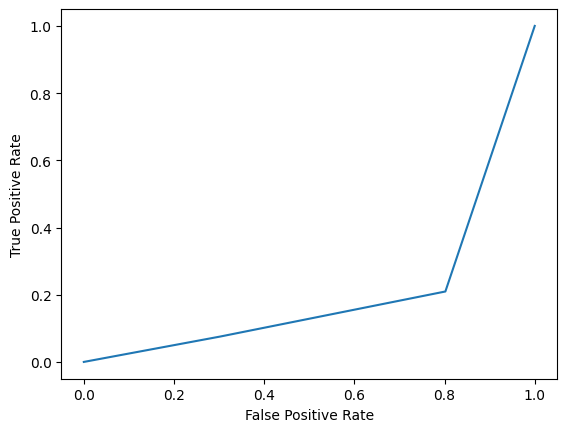

In [63]:
fpr, tpr, _ = roc_curve(y_test, clf.predict(X_test),  pos_label=clf.classes_[0])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

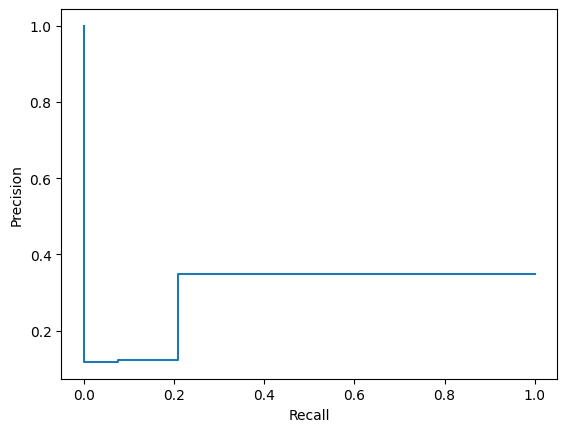

In [64]:
prec, recall, _ = precision_recall_curve(y_test, clf.predict(X_test),  pos_label=clf.classes_[0])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

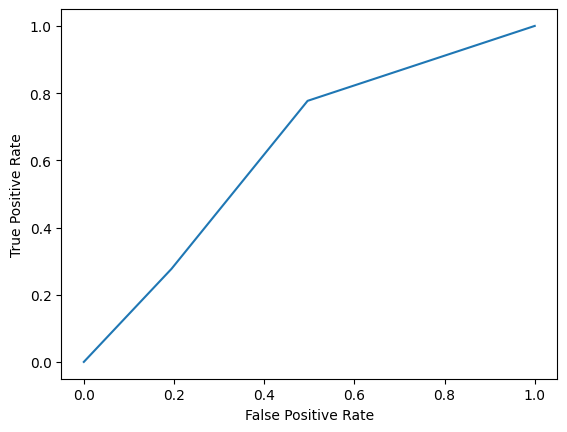

In [65]:
fpr, tpr, _ = roc_curve(y_test, clf.predict(X_test), pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

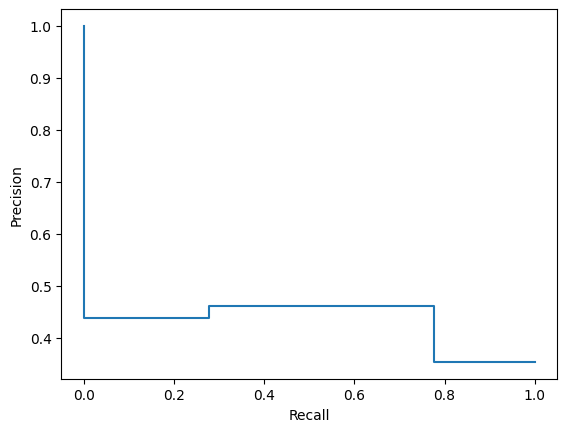

In [66]:
prec, recall, _ = precision_recall_curve(y_test, clf.predict(X_test), pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

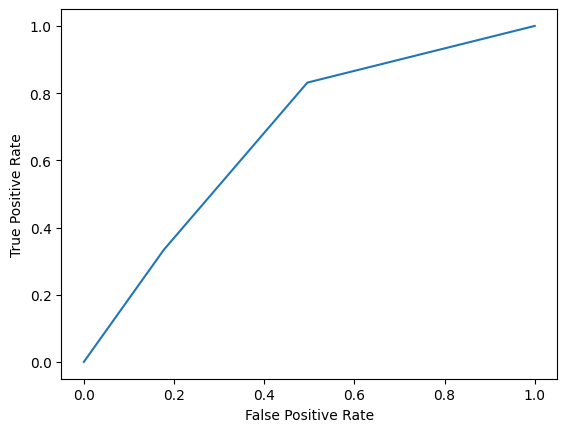

In [67]:
fpr, tpr, _ = roc_curve(y_test, clf.predict(X_test), pos_label=clf.classes_[2])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

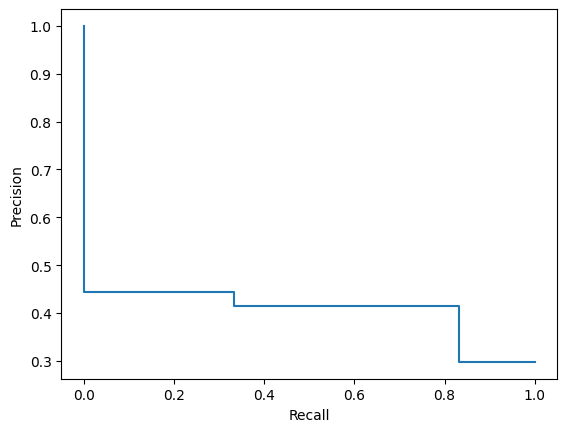

In [68]:
prec, recall, _ = precision_recall_curve(y_test, clf.predict(X_test), pos_label=clf.classes_[2])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [69]:
unique, counts = np.unique(y_test, return_counts = True)
for i in range (0, len(unique)):
    print(f'кількість значень {unique[i]} = {counts[i]}')

кількість значень -1 = 291
кількість значень 10 = 296
кількість значень 20 = 249


по работе с тремя классами и графиками видно, что при делении на три класса плохие результаты(модель часто путает мужскую и женскую осыби). Для маленьких взрослых осыбей чаще идет предикт на ребенка, в связи с чем проваливается вниз(так как детей в тестовых данных меньше всего). попробуем поделить на два класса(дети и взрослые)

In [70]:
dct = {10: 1, 20: 1, -1: -1}
database['Sex_numeric'] = database['Sex_numeric'].map(dct)

In [71]:
database

,Sex,Length,Height,Whole weight,Rings,Ratio,Weight loss,Shell density,Fleshiness,Global density,Sex_numeric
0,M,0.455,0.095,0.5140,15,1.246575,0.449889,0.451603,3.426667,0.030695,1
1,M,0.350,0.090,0.2255,7,1.320755,0.487437,0.377358,3.221429,0.037018,1
2,F,0.530,0.135,0.6770,9,1.261905,0.551657,0.471698,3.223810,0.044388,1
3,M,0.440,0.125,0.5160,10,1.205479,0.529002,0.482565,3.329032,0.038905,1
4,I,0.330,0.080,0.2050,7,1.294118,0.441341,0.326797,3.727273,0.032839,-1
...,...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.165,0.8870,11,1.255556,0.645946,0.489676,3.562249,0.047296,1
4173,M,0.590,0.135,0.9660,10,1.340909,0.488610,0.501733,3.708253,0.036280,1
4174,M,0.600,0.205,1.1760,9,1.263158,0.547098,0.540351,3.818182,0.049681,1
4175,F,0.625,0.150,1.0945,10,1.288660,0.491525,0.488247,3.697635,0.041543,1


In [72]:
y = np.array(database['Sex_numeric'])
X = database.drop(columns= ['Sex_numeric', 'Sex'])

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)

In [74]:
reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [75]:
print(classification_report(y_test, reg.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.72      0.72      0.72       273
           1       0.86      0.86      0.86       563

    accuracy                           0.82       836
   macro avg       0.79      0.79      0.79       836
weighted avg       0.82      0.82      0.82       836



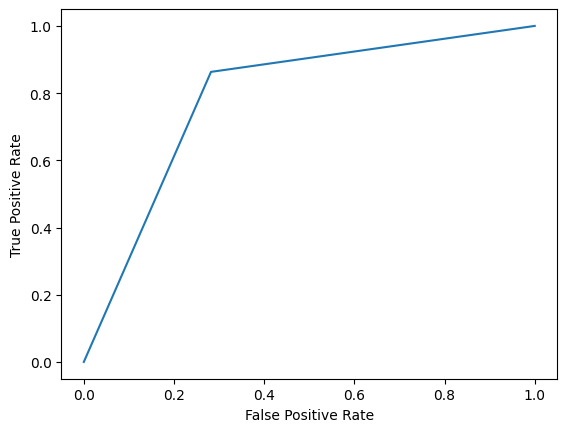

In [76]:
fpr, tpr, _ = roc_curve(y_test, reg.predict(X_test))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

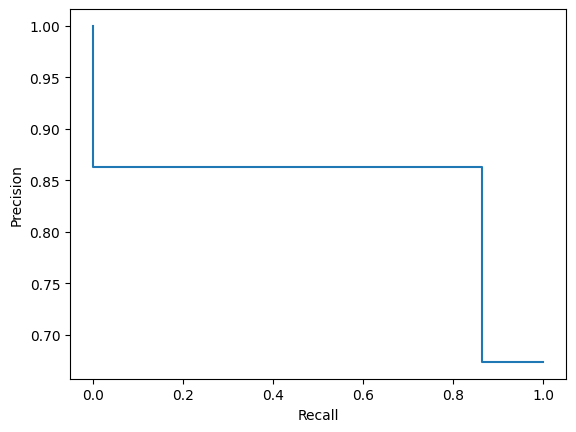

In [77]:
prec, recall, _ = precision_recall_curve(y_test, reg.predict(X_test))
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [78]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree'],
                         'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
                         'kneighborsclassifier__p': [1, 2, 3],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']})

In [79]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.73      0.73      0.73       273
           1       0.87      0.87      0.87       563

    accuracy                           0.82       836
   macro avg       0.80      0.80      0.80       836
weighted avg       0.82      0.82      0.82       836



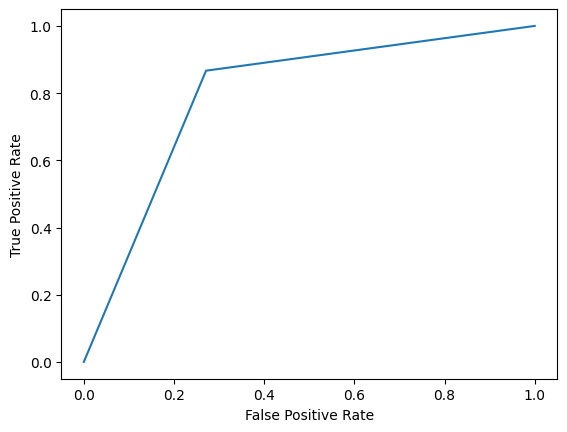

In [80]:
fpr, tpr, _ = roc_curve(y_test, clf.predict(X_test))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

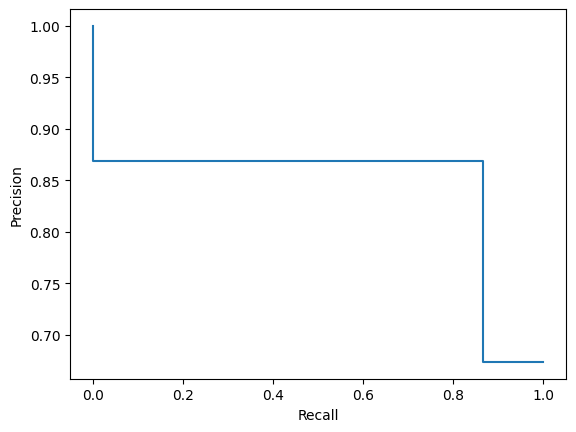

In [81]:
prec, recall, _ = precision_recall_curve(y_test, clf.predict(X_test))
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

графики и показатели довольно хорошие при делении на два класса. различия результатов со стандартными гиперпараметрами и вариацией других не появилось. стандартные гиперпараметры являются более оптимальными. Делить мужских и женских осыбей не имеет смысла, так как имеющиеся признаки у них не отличаются.